# Network Models: Small World
### Deadline till 19.02.2019, -1 points after 19.02.2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import matplotlib.colors as mcolors
%matplotlib inline

During this seminar we will work with **Watts and Strogatz model**.
Again, the idea of the model:

1. Start with regular lattice with N nodes, K nearest neighbours
2. For each node take every edge and rewire it with probability $p$, assuming that there is no loops and edge duplications

##### Task

 1. Implement *rewind(G, p)* function that takes graph G and probability p as input. The function should produce a graph after step 2 of the model above. 
 2. Run experiments for various values of p, compute and show 
     * average path length 
     * clustering coefficients (transitivity) 
     * degree distribution     
 3. Compute centrality metrics for the [network](http://www-personal.umich.edu/~mejn/netdata/polblogs.zip) (including eigenvector, Katz, local load centralities) and highlight interaction between vertices with the highest degree. Plot the interesting cases and interpret them.
 4. Try to model the network from (3) with Small World Model and Erdos-Renyi Model.
 5. Plot the dependencies between different centrality metrics for the network and the simultaed graphs. Are there any correlations between centrality metrics? Explain the differences.

In [2]:
def gen_regular_graph(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for j in range(1, k // 2+1):
        targets = nodes[j:] + nodes[0:j] # first j nodes are now last in list
        G.add_edges_from(zip(nodes,targets))
    return G

def degree_distr(k, bins = 100):
    yh, binEdges = np.histogram(k, bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return yh, bincenters

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


0.5

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


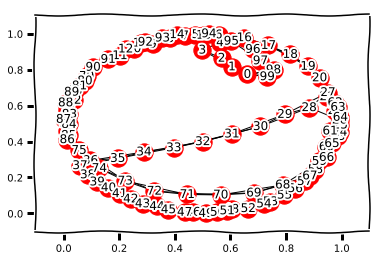

In [3]:
graph = gen_regular_graph(100, 4)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph,pos)
nx.transitivity(graph)

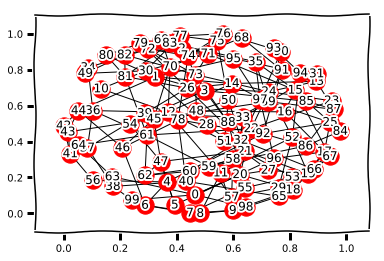

In [4]:
def rewind(graph, p):
    graph = nx.Graph(graph)
    edges = graph.edges()
    nodes = graph.nodes()
    for edge in edges:
        n = edge[0]
        adj_n = edge[1]
        if np.random.random() < p:
            adjacent = list(graph.neighbors(n))
            available_nodes = list(set(nodes).difference(set(adjacent)).union(set([adj_n])))
            new_vertex = np.random.choice(available_nodes)
            graph.remove_edge(n, adj_n)
            graph.add_edge(n, new_vertex)
            #print('removed', n, adj_n)
            #print('added', n, new_vertex)
        
    return graph
    
rewinded_graph = rewind(graph, 0.5)
pos = nx.spring_layout(rewinded_graph)
nx.draw_networkx(rewinded_graph, pos)

In [5]:
def small_world_graph(n, k, p):
    regular = gen_regular_graph(n, k) 
    return rewind(regular, p)

In [6]:
num_graphs = 30
n = 100
k = 10
p_values = np.geomspace(0.0001, 1, 20)
graphs = {}
for p in p_values:
    graphs[p] = [small_world_graph(n, k, p) for i in range(num_graphs)]

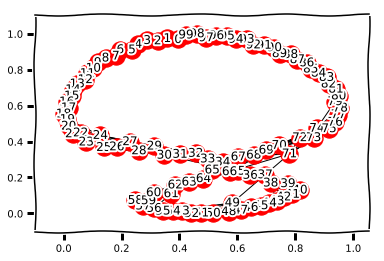

In [7]:
g = graphs[sorted(list(graphs.keys()))[2]][0]
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos)

In [8]:
# Compute statistics over graphs
stats = {}
for p in p_values:
    gs = graphs[p]
    sps = [nx.average_shortest_path_length(next(nx.connected_component_subgraphs(g))) for g in gs]
    average_sp = np.mean(sps)
    ts = [nx.average_clustering(g) for g in gs]
    average_t = np.mean(ts)
    stats[p] = {
        'sp': average_sp,
        't': average_t,
    }
df = pd.DataFrame.from_dict(stats, orient='index')

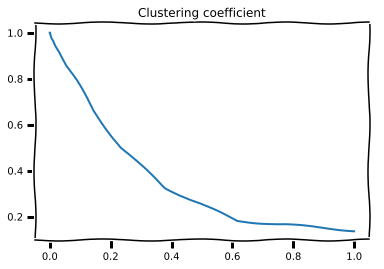

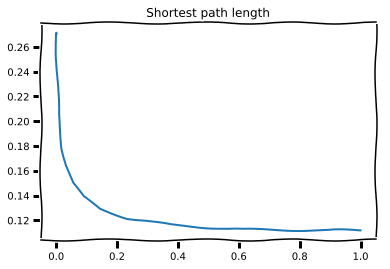

In [9]:
df['t_norm'] = df.t / nx.average_clustering(gen_regular_graph(n, k))
df['sp_norm'] = df.sp / (2 * n / k)
plt.title('Clustering coefficient')
df.t_norm.plot()
plt.show()
df.sp_norm.plot()
plt.title('Shortest path length')
plt.show()

In [10]:
df.head()

,sp,t,t_norm,sp_norm
0.000100,5.405125,0.666399,0.999599,0.270256
0.000162,5.393239,0.666052,0.999079,0.269662
0.000264,5.415300,0.666338,0.999507,0.270765
0.000428,5.430148,0.666279,0.999418,0.271507
0.000695,5.317710,0.665144,0.997716,0.265886


Investigate degree distribution


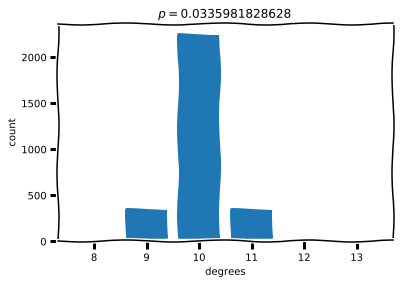

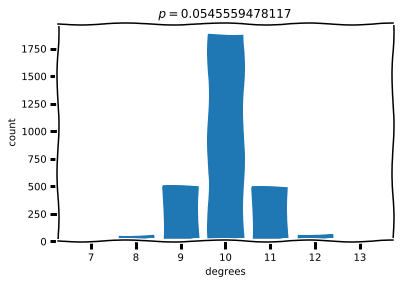

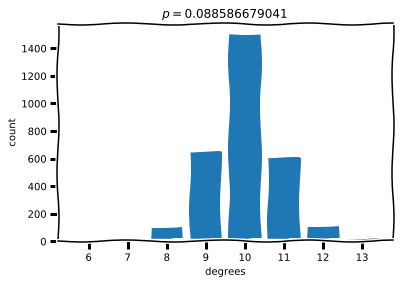

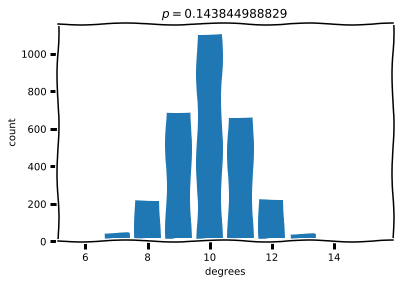

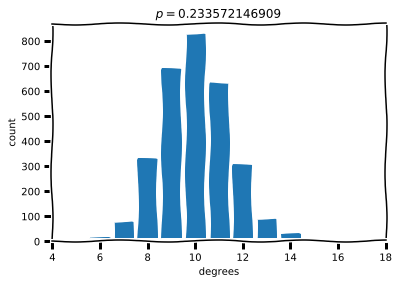

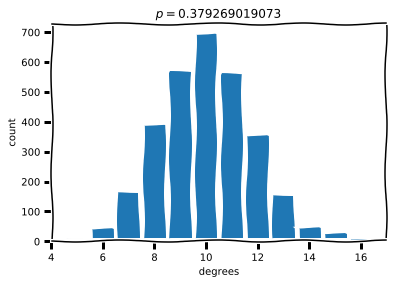

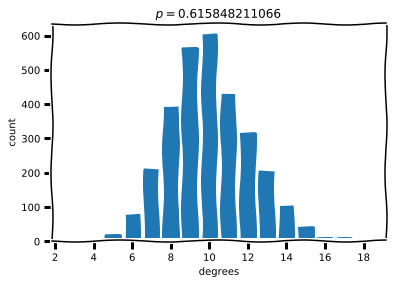

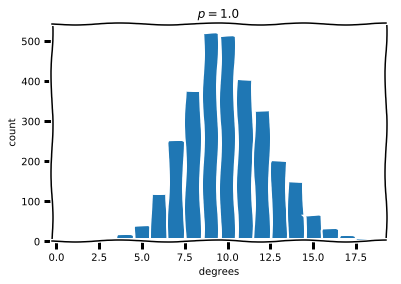

In [11]:
print("Investigate degree distribution")
def plot_hist(degrees, bins=1000):
    yh, binEdges = np.histogram(degrees, bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.bar(bincenters, yh)
    plt.ylabel('count')
    plt.xlabel('degrees')
    plt.show()

for p in p_values[-8:]:
    gs = graphs[p]
    node_degrees = np.hstack([g.degree().values() for g in gs])
    plt.title('$p = {}$'.format(p))
    plot_hist(node_degrees)
    plt.show()

Degree distribution tends to Gaussian as p increases.

# Polblogs

In [13]:
polblogs = nx.Graph(nx.read_gml("polblogs.gml").to_undirected())

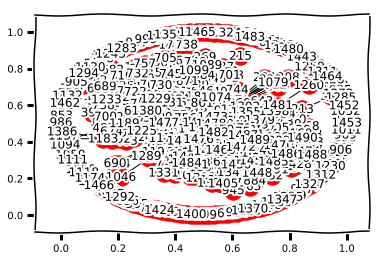

In [27]:
pos = nx.spring_layout(polblogs)
nx.draw_networkx(polblogs,pos)

Graph is too large to plot wholly. We need to select a subset of nodes.

In [28]:
def draw(G, pos, measures, colors, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos,
                                   cmap=plt.cm.plasma, 
                                   node_size=[c*1500 for c in measures],
                                   node_color=colors,
                                   nodelist=G.nodes())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.05)

    plt.title(measure_name)
    plt.axis('off')
    plt.show()

The graph is attributed, marking blogs as left or right. We will use it to color the graph later. Node size proportional to degree centrality.

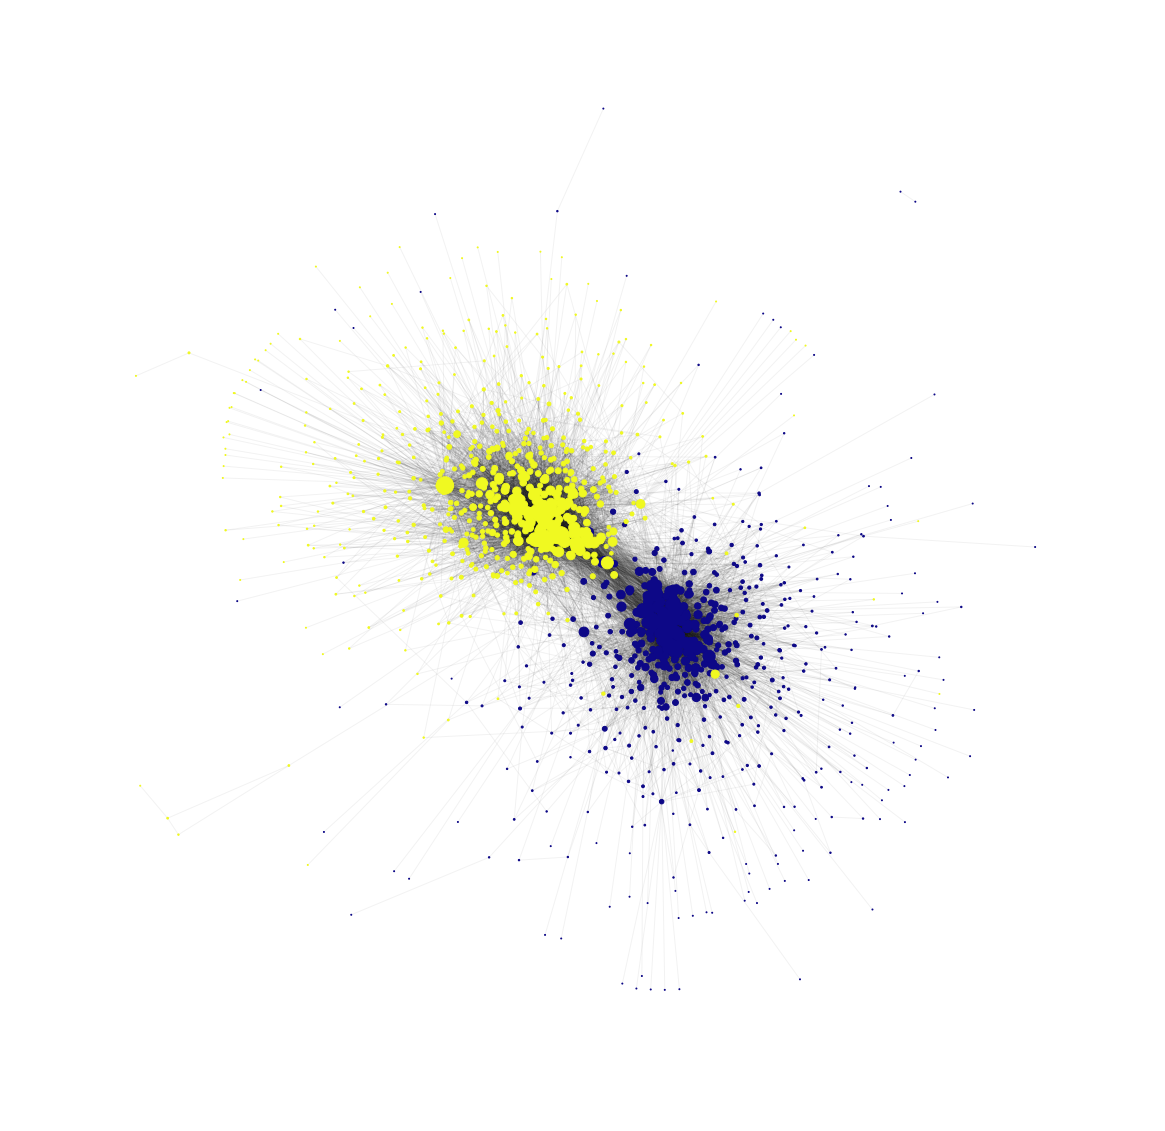

In [16]:
# Degree centrality
pos = nx.spring_layout(polblogs)
dc = nx.degree_centrality(polblogs)
degree_centralities = dc
plt.figure(1, figsize=(20,20))
draw(polblogs, pos, dc.values(), nx.get_node_attributes(polblogs, 'value').values(), 'Degree centrality')

Let's select nodes that have a centrality higher than the $0.5$ quantile, for each centrality measure.

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


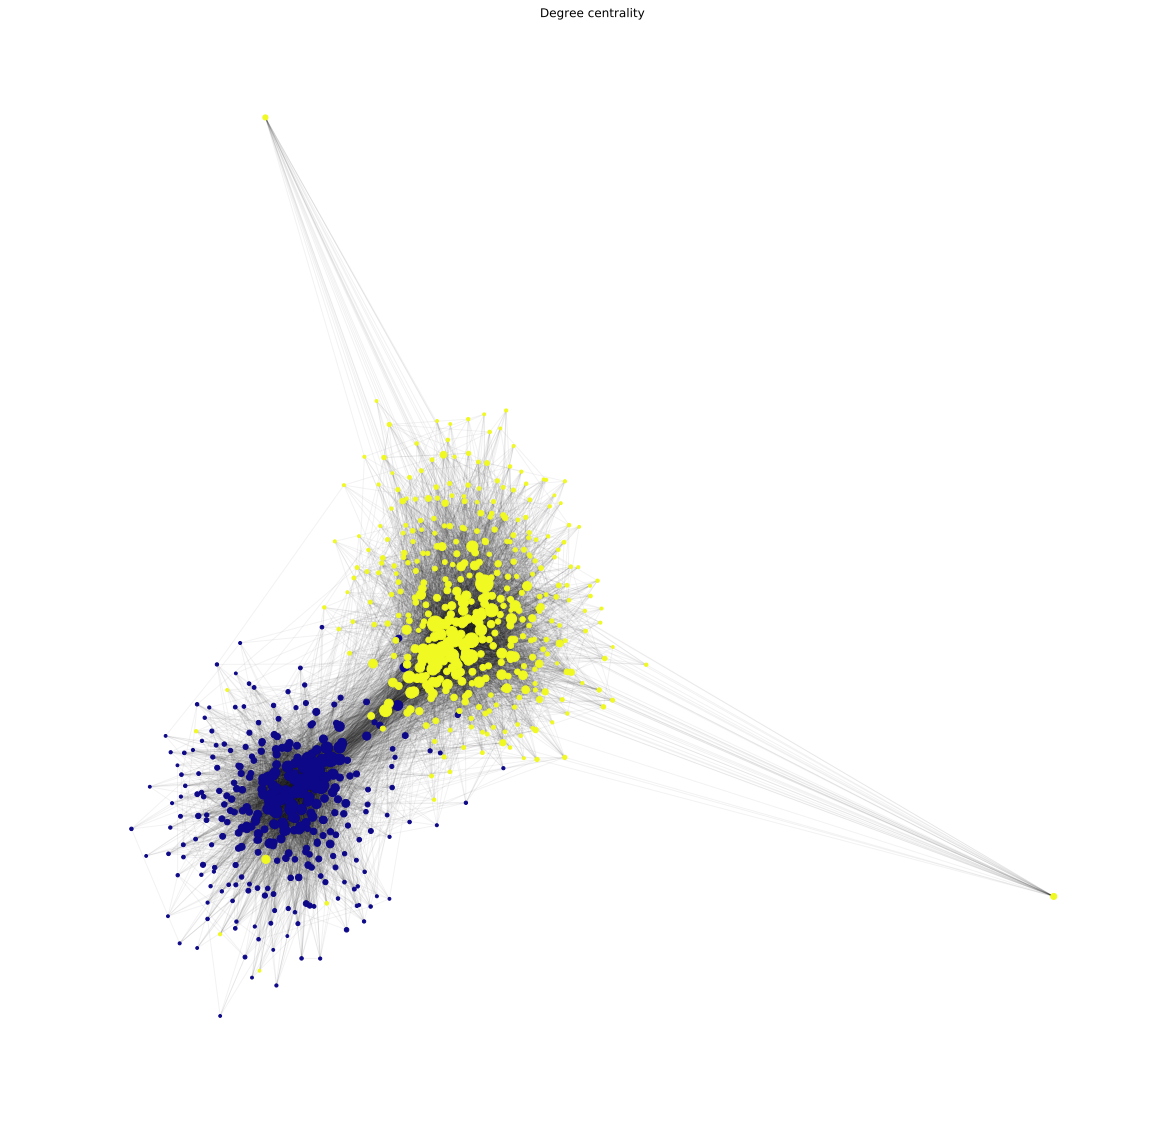

In [29]:
dcs = pd.Series(dc)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Degree centrality')

We can clearly observe two clusters! Right-wing and left-wing blogs

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


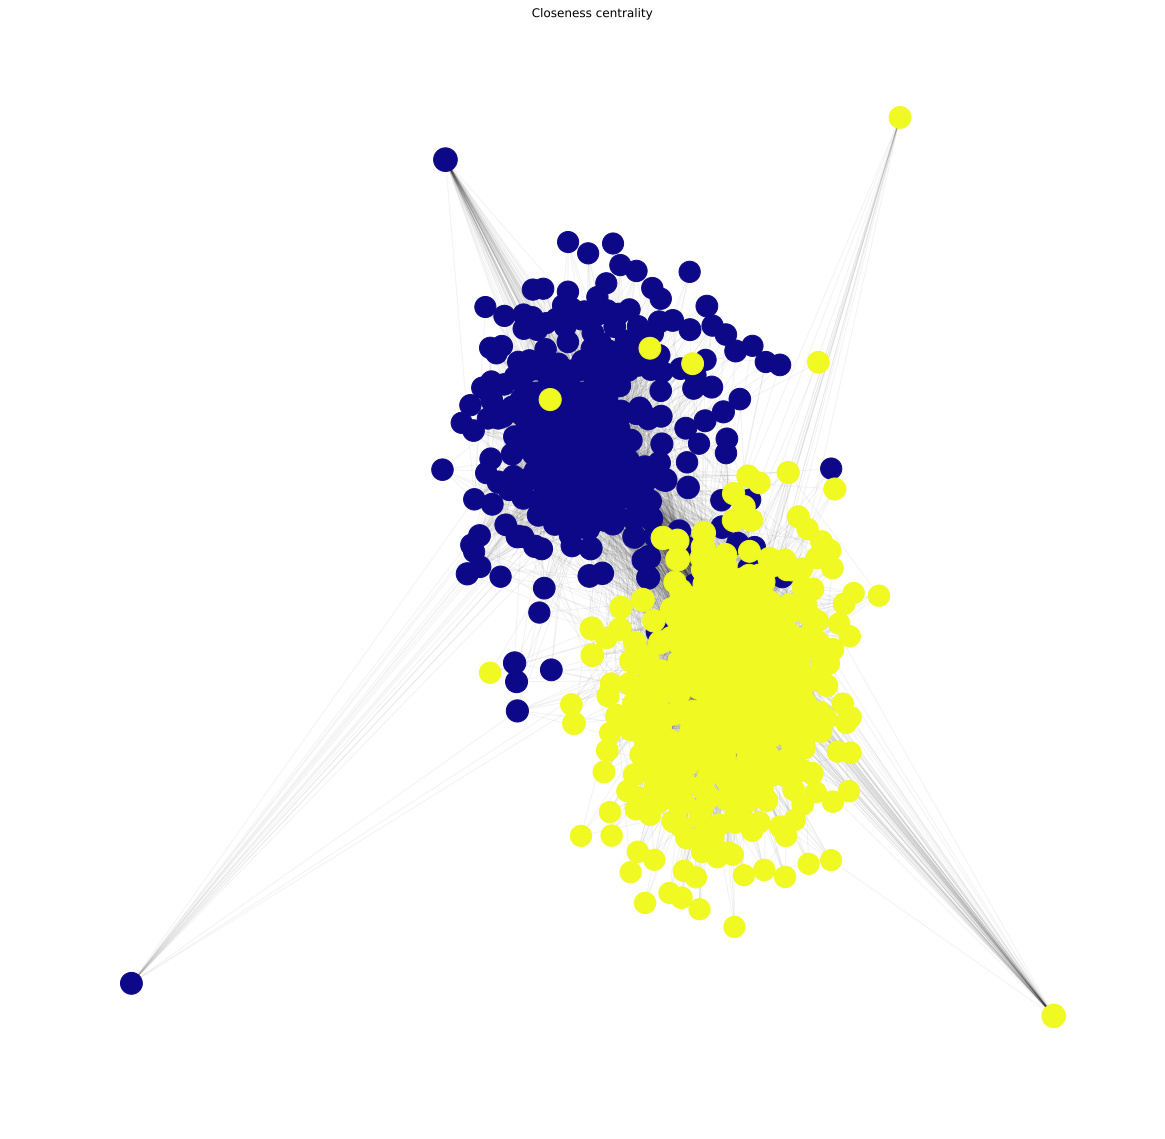

In [30]:
# Closeness centrality
cm = nx.closeness_centrality(polblogs)
closeness_centralities = cm
dcs = pd.Series(cm)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Closeness centrality')

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


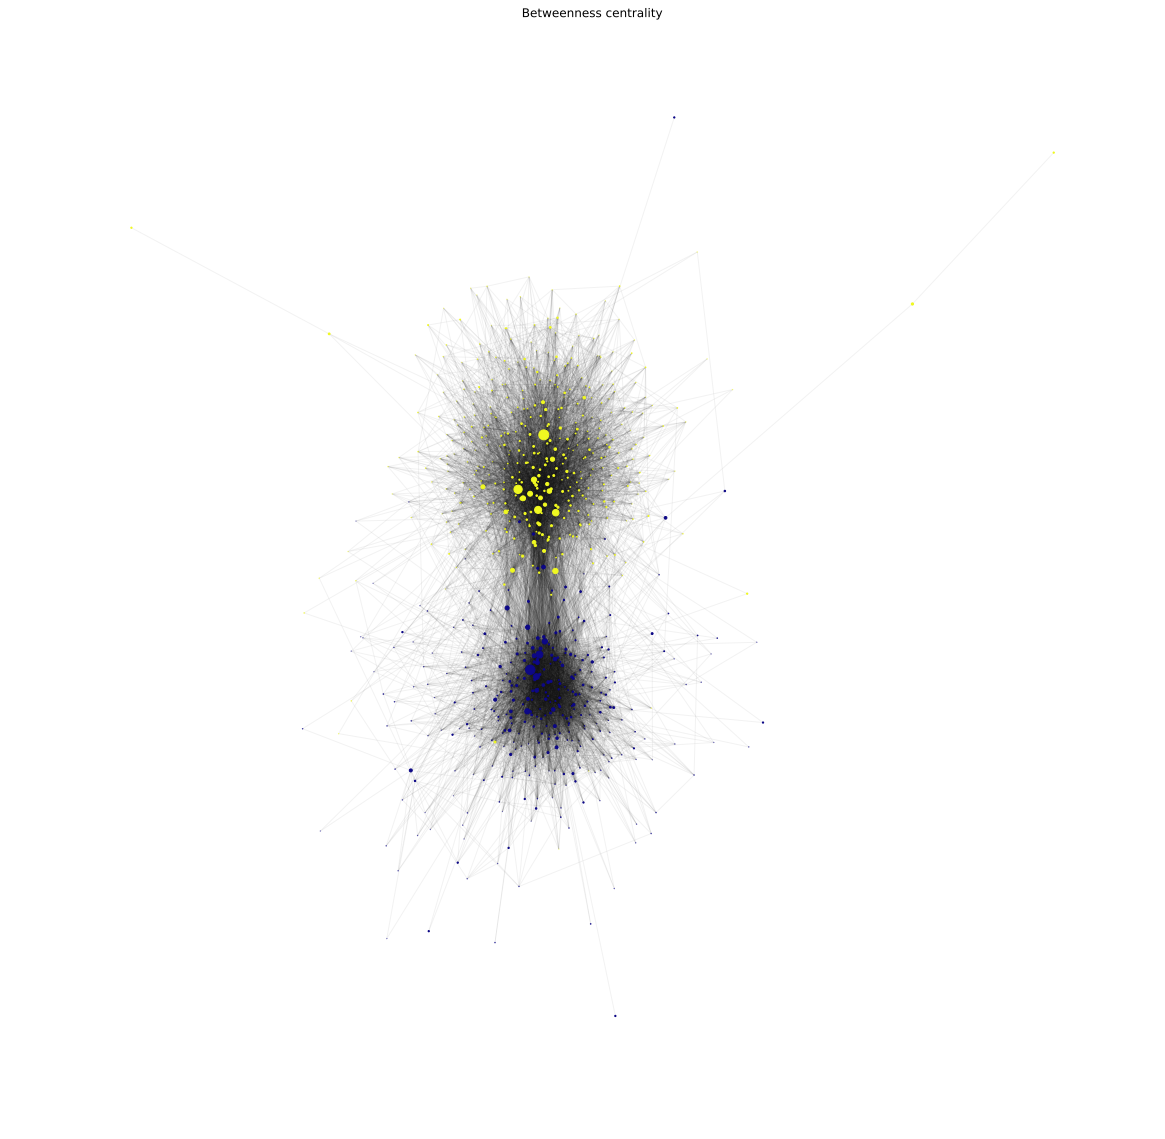

In [31]:
# Betweenness centrality
cm = nx.betweenness_centrality(polblogs)
dcs = pd.Series(cm)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Betweenness centrality')

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


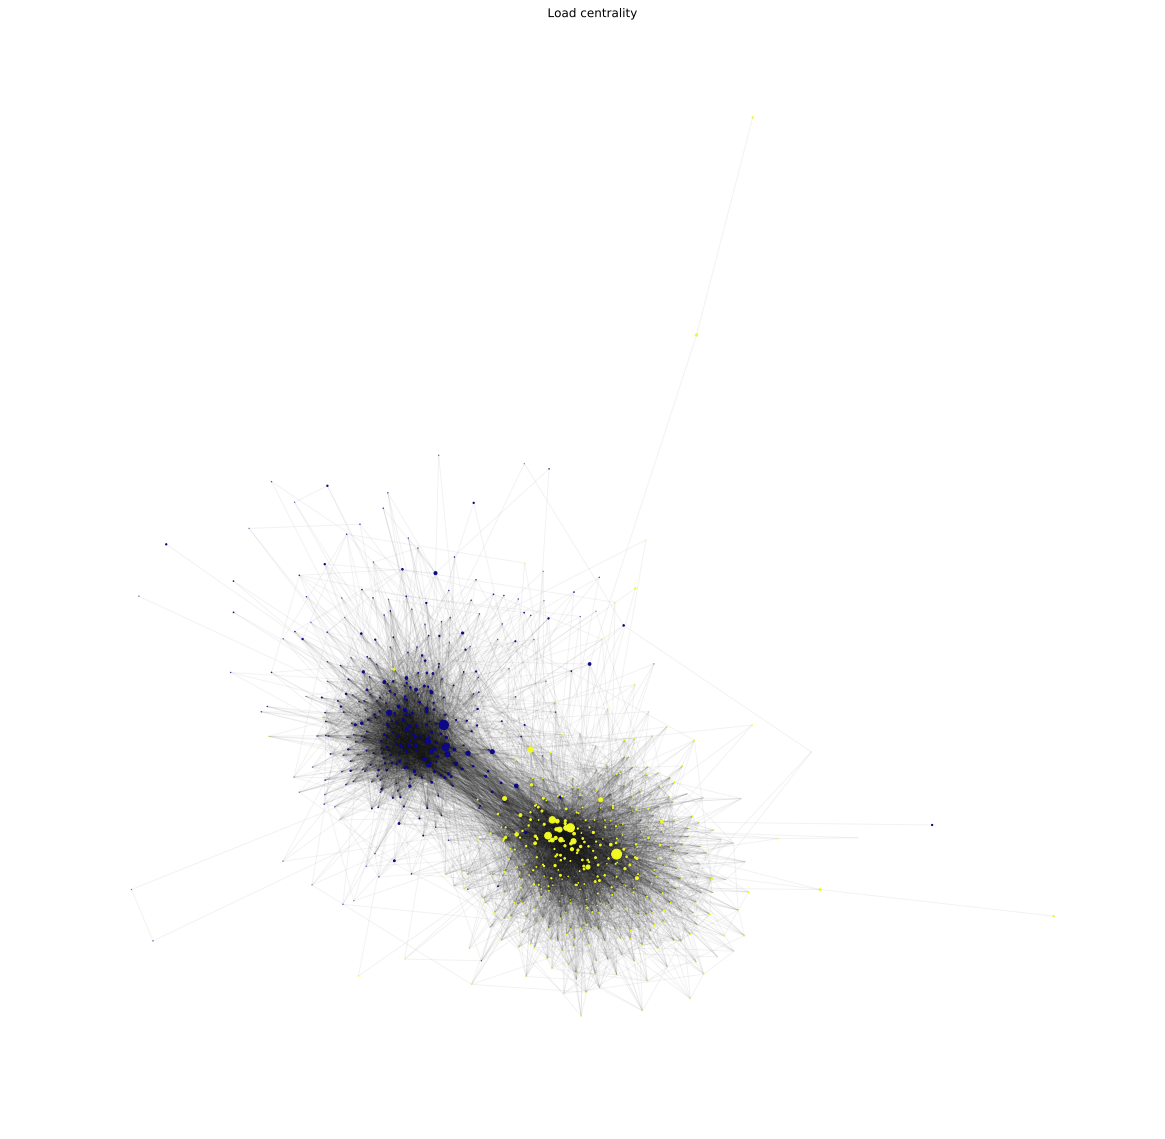

In [32]:
# Load centrality
cm = nx.load_centrality(polblogs)

dcs = pd.Series(cm)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Load centrality')

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


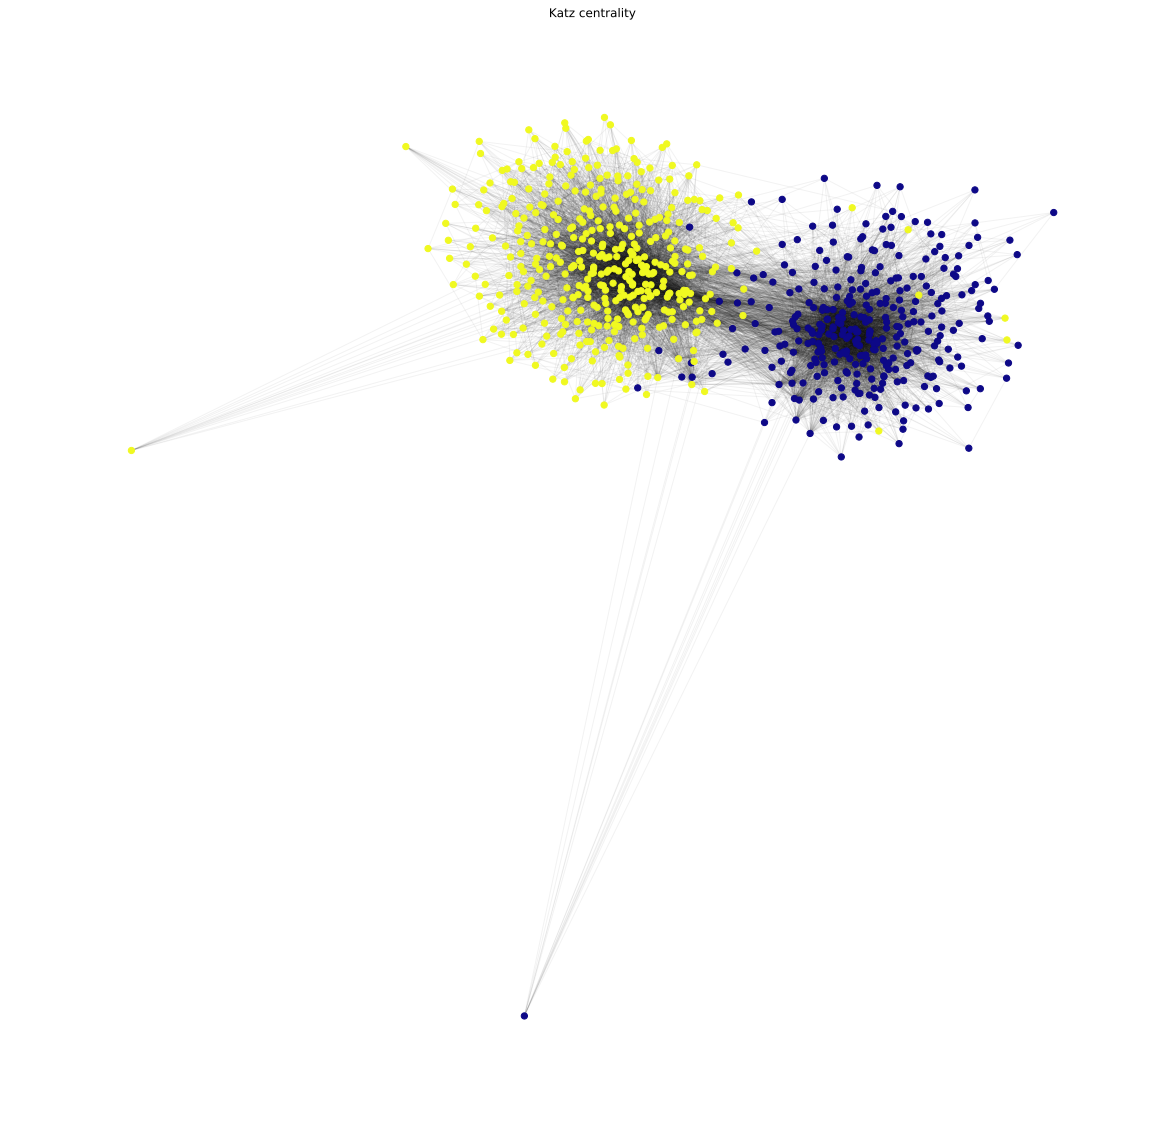

In [33]:
# Katz centrality
cm = nx.katz_centrality(polblogs, alpha=0.00001, beta=0.0001)
katz_centralities = cm

dcs = pd.Series(cm)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Katz centrality')

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


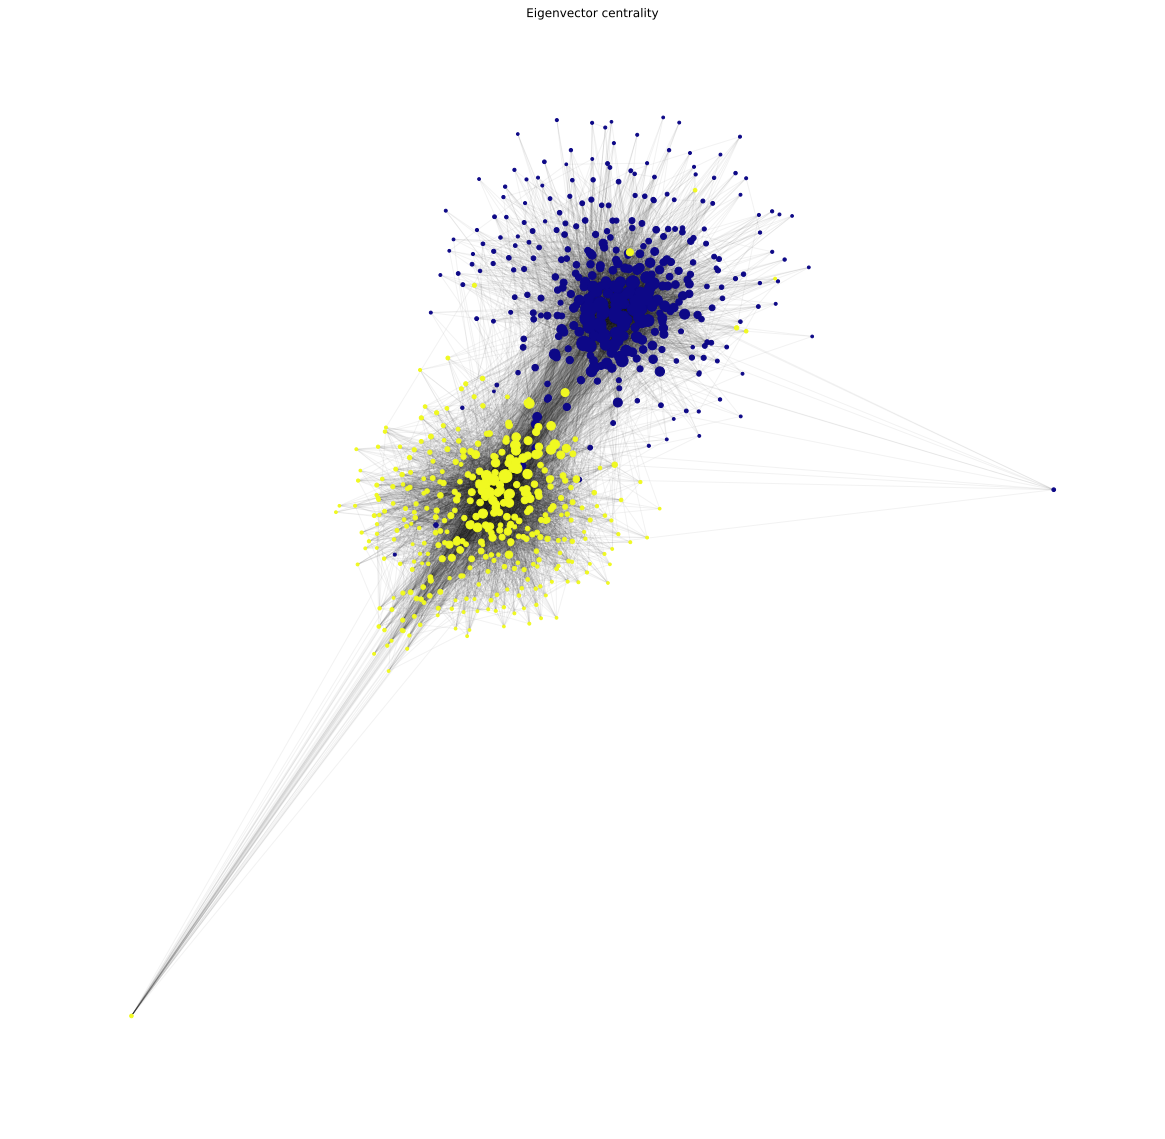

In [34]:
# Eigenvector centrality
cm = nx.eigenvector_centrality(polblogs)
eigenvector_centralities = cm

dcs = pd.Series(cm)
mask = dcs > dcs.quantile(0.5)
nodes = pd.Series(polblogs.nodes())
nodes.index = mask.index
subgraph_nodes = nodes.ix[mask]
subgraph_dcs = dcs.ix[mask]
subgraph = nx.subgraph(polblogs, subgraph_nodes)
plt.figure(1, figsize=(20,20))
draw(subgraph, nx.spring_layout(subgraph), subgraph_dcs, nx.get_node_attributes(subgraph, 'value').values(), 'Eigenvector centrality')

In [25]:
corr = np.corrcoef([degree_centralities.values(),eigenvector_centralities.values(),katz_centralities.values()])
pd.DataFrame(corr, columns=['degree centrality', 'eigenvector centrality', 'katz centrality'], index=['degree centrality', 'eigenvector centrality', 'katz centrality'])

,degree centrality,eigenvector centrality,katz centrality
degree centrality,1.000000,0.893879,0.999999
eigenvector centrality,0.893879,1.000000,0.893875
katz centrality,0.999999,0.893875,1.000000


As we can see centrality measures are highly correlated. Katz centrality is more correlated with degree centrality, whilist eigenvector is set apart from others.